Install libraries

In [17]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


Import libraries

In [1]:
import h5py
import os
import cv2
import tensorflow.keras as tfk
import random
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import *
from keras.models import *
from keras.layers import *
#import segmentation_models as sm
import keras.backend as K
from tensorflow.keras.utils import normalize

Coonect google drive if using Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
image_dir = '/content/drive/MyDrive/thyroid/images'
mask_dir = '/content/drive/MyDrive/thyroid/mask'

img_files  = sorted(os.listdir(image_dir))
msk_file = sorted(os.listdir(mask_dir))

Train,Valid, Test split

In [12]:
from sklearn.model_selection import train_test_split
train_img_files1,valid_img_files = train_test_split(img_files, test_size = 0.2,random_state =2) 
train_msk_files1,valid_msk_files = train_test_split(msk_file, test_size = 0.2,random_state=2) 

train_img_files,test_img_files = train_test_split(train_img_files1, test_size = 0.2,random_state =2) 
train_msk_files,test_msk_files = train_test_split(train_msk_files1, test_size = 0.2,random_state=2) 

In [13]:
class_values = [0,1,2]

def customDataset(image_list, mask_list, input_size=(256,256), channel=1, ):
  X = np.zeros((len(image_list),) + input_size + (channel,), dtype=np.float32)
  Y = np.zeros((len(image_list),) + input_size + (len(class_values),), dtype=np.uint8)


  for i in tqdm(range((len(image_list)))):
    img = cv2.imread(os.path.join(image_dir+'/'+ image_list[i] ))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img= cv2.resize(img,input_size)
    img = normalize(img)
    img= np.expand_dims(img, axis = 2)
  

    msk = cv2.imread(os.path.join(mask_dir+'/'+ mask_list[i] ),0)
    msk = cv2.resize(msk,(256,256))

    y_train = [(msk == v) for v in class_values]
    mask_stacked = np.stack(y_train, axis=-1).astype(np.uint8)

    X[i] = img
    Y[i] = mask_stacked

  return X, Y

In [14]:
XTrain, YTrain = customDataset(train_img_files, train_msk_files)

100%|██████████| 828/828 [00:05<00:00, 150.98it/s]


In [15]:
XValid, YValid = customDataset(valid_img_files, valid_msk_files)

100%|██████████| 259/259 [00:02<00:00, 125.85it/s]


In [16]:
XTest, YTest = customDataset(test_img_files, test_msk_files)

100%|██████████| 208/208 [00:01<00:00, 151.59it/s]


     |████████████████████████████████| 1.1 MB 6.2 MB/s 


In [18]:
import tensorflow_addons as tfa

In [19]:
inputs = Input((256,256,1))
conv1 = tf.keras.layers.SeparableConvolution2D(64,3,padding='same', activation= 'relu', depth_multiplier=1 )(inputs)
conv1 = tf.keras.layers.SeparableConvolution2D(64,3,padding='same', activation= 'relu' , depth_multiplier=1 )(conv1)
bn1= tfa.layers.GroupNormalization( groups= 4,)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

conv2 = tf.keras.layers.SeparableConvolution2D(128,3,padding='same', activation= 'relu', depth_multiplier=1  )(pool1)
conv2 = tf.keras.layers.SeparableConvolution2D(128,3,padding='same', activation= 'relu', depth_multiplier=1  )(conv2)
bn2= tfa.layers.GroupNormalization( groups= 4,)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

conv3 = tf.keras.layers.SeparableConvolution2D(256,3,padding='same', activation= 'relu' , depth_multiplier=1 )(pool2)
conv3 = tf.keras.layers.SeparableConvolution2D(256,3,padding='same', activation= 'relu' , depth_multiplier=1 )(conv3)
bn3= tfa.layers.GroupNormalization( groups= 4,)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

conv5 = tf.keras.layers.SeparableConvolution2D(512,3,padding='same', activation= 'relu' , depth_multiplier=1 )(pool3)
conv5 = tf.keras.layers.SeparableConvolution2D(512,3,padding='same', activation= 'relu' , depth_multiplier=1 )(conv5)

up7 = tf.keras.layers.SeparableConvolution2D(256,3,padding='same', activation= 'relu' , depth_multiplier=1)(UpSampling2D(size = (2,2))(conv5))
merge7 = concatenate([bn3,up7], axis = 3)
conv7 = tf.keras.layers.SeparableConvolution2D(256,3,padding='same', activation= 'relu', depth_multiplier=1  )(merge7)
conv7 = tf.keras.layers.SeparableConvolution2D(256,3,padding='same', activation= 'relu' , depth_multiplier=1 )(conv7)
bn7= tfa.layers.GroupNormalization( groups= 4,)(conv7)

up8 = tf.keras.layers.SeparableConvolution2D(128,3,padding='same', activation= 'relu' , depth_multiplier=1 )(UpSampling2D(size = (2,2))(bn7))
merge8 = concatenate([bn2,up8], axis = 3)
conv8 = tf.keras.layers.SeparableConvolution2D(128,3,padding='same', activation= 'relu' , depth_multiplier=1 )(merge8)
conv8 = tf.keras.layers.SeparableConvolution2D(128,3,padding='same', activation= 'relu' , depth_multiplier=1 )(conv8)
bn8= tfa.layers.GroupNormalization( groups= 4,)(conv8)

up9 = tf.keras.layers.SeparableConvolution2D(64,3,padding='same', activation= 'relu', depth_multiplier=1 )(UpSampling2D(size = (2,2))(bn8))
merge9 = concatenate([bn1,up9], axis = 3)
conv9 = tf.keras.layers.SeparableConvolution2D(64,3,padding='same', activation= 'relu', depth_multiplier=1  )(merge9)
conv9 = tf.keras.layers.SeparableConvolution2D(64,3,padding='same', activation= 'relu', depth_multiplier=1  )(conv9)
conv9 = tf.keras.layers.SeparableConvolution2D(8,3,padding='same', activation= 'relu' , depth_multiplier=1 )(conv9)
bn9= tfa.layers.GroupNormalization( groups= 4,)(conv9)
conv10 = tf.keras.layers.SeparableConvolution2D(3,3,padding='same', activation= 'softmax' , depth_multiplier=1 )(bn9)

model = Model(inputs = inputs, outputs = conv10)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 64  137        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 256, 256, 64  4736       ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

In [21]:
LR= 0.001
optim = tfk.optimizers.Adam()
loss= tf.keras.losses.CategoricalCrossentropy()
metrics=['accuracy']
model.compile(optim,loss, metrics)

In [22]:
# train model
callback= [tfk.callbacks.ReduceLROnPlateau(patience= 20, verbose= 2, monitor= 'val_loss')]
history = model.fit(XTrain,YTrain,epochs= 10, batch_size= 16,validation_data= (XValid,YValid), shuffle= True)

Epoch 1/10
52/52 [==============================] - 112s 2s/step - loss: 0.6053 - accuracy: 0.9294 - val_loss: 0.2668 - val_accuracy: 0.9431
Epoch 2/10
52/52 [==============================] - 96s 2s/step - loss: 0.1895 - accuracy: 0.9483 - val_loss: 0.1509 - val_accuracy: 0.9499
Epoch 3/10
52/52 [==============================] - 96s 2s/step - loss: 0.1236 - accuracy: 0.9595 - val_loss: 0.1053 - val_accuracy: 0.9646
Epoch 4/10
52/52 [==============================] - 96s 2s/step - loss: 0.1082 - accuracy: 0.9624 - val_loss: 0.1025 - val_accuracy: 0.9619
Epoch 5/10
52/52 [==============================] - 96s 2s/step - loss: 0.0891 - accuracy: 0.9685 - val_loss: 0.0851 - val_accuracy: 0.9682
Epoch 6/10
52/52 [==============================] - 96s 2s/step - loss: 0.0831 - accuracy: 0.9698 - val_loss: 0.0783 - val_accuracy: 0.9704
Epoch 7/10
52/52 [==============================] - 96s 2s/step - loss: 0.0796 - accuracy: 0.9707 - val_loss: 0.0762 - val_accuracy: 0.9717
Epoch 8/10
52/52 [=

Save full model 

In [23]:
model.save('/content/drive/MyDrive/thyroid/thyroid_depthwise_multiclass_512Filters.h5')

Test model on exclusive test set

In [24]:
model.evaluate(XTest,YTest)

7/7 [==============================] - 5s 515ms/step - loss: 0.0591 - accuracy: 0.9767


[0.05910676345229149, 0.9766668677330017]

In [25]:
test= model.predict(XTest, verbose=1)
pred= (test>0.5).astype(np.float32)

7/7 [==============================] - 4s 556ms/step


In [26]:
pred = np.argmax(pred, axis = -1)
pred.shape

(208, 256, 256)

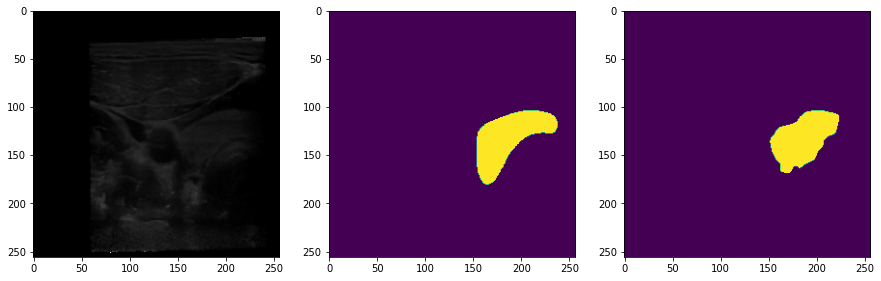

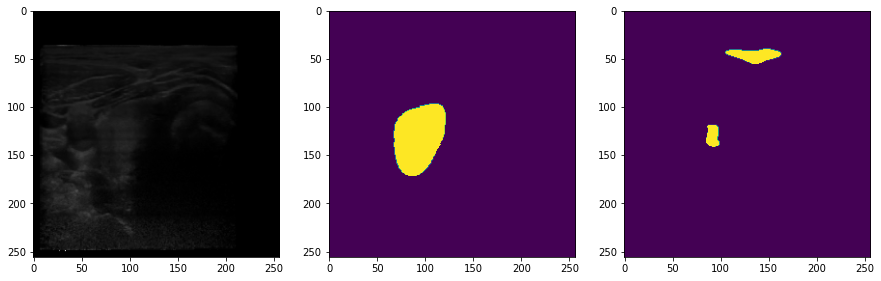

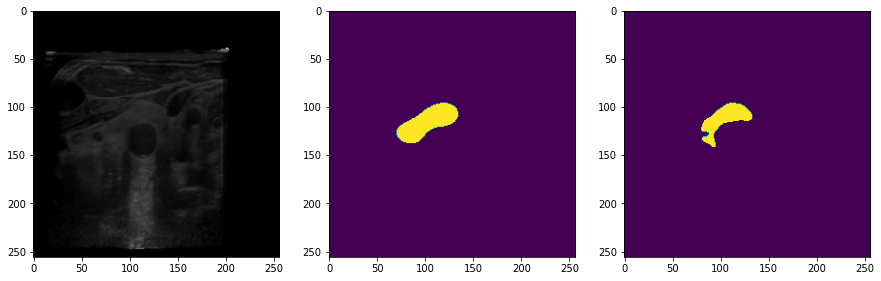

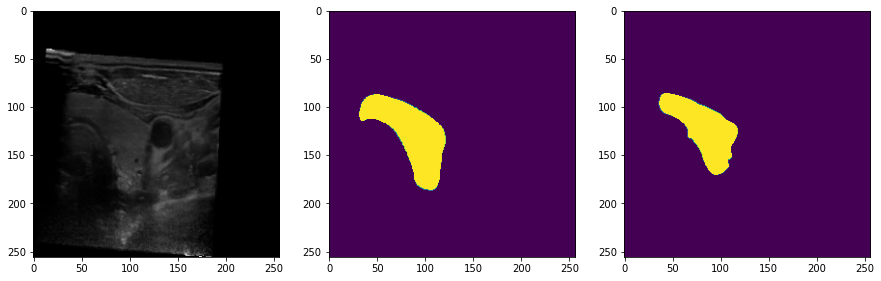

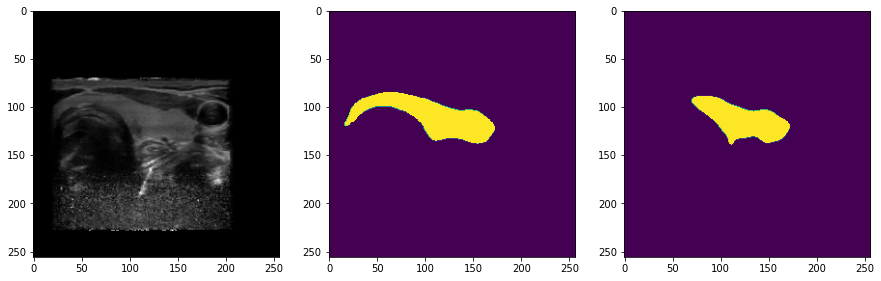

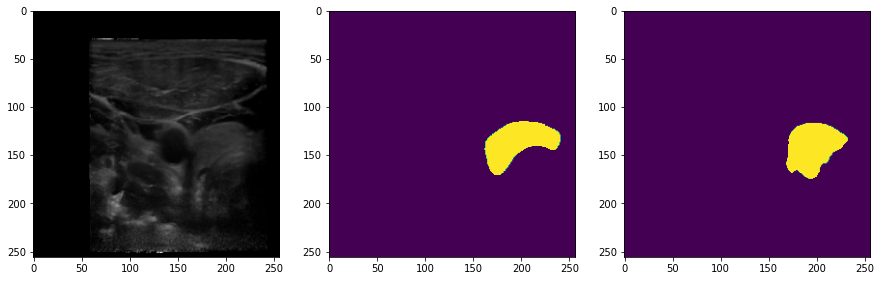

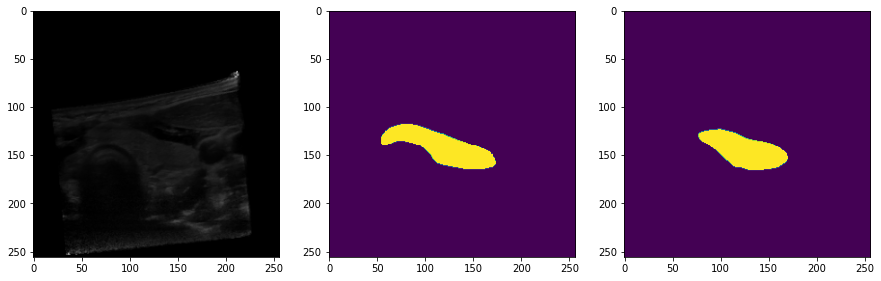

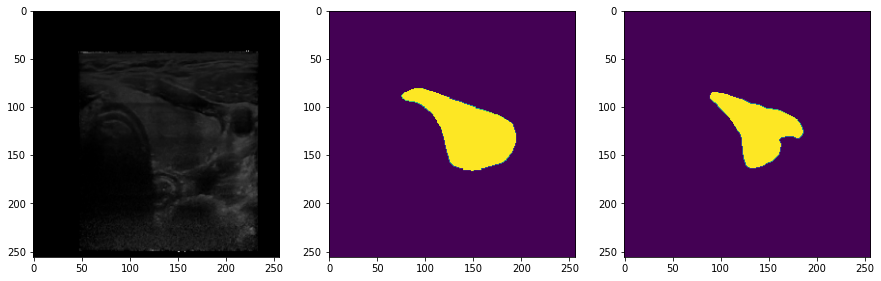

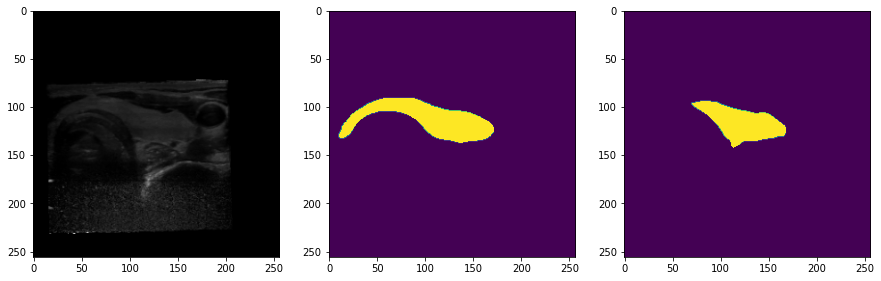

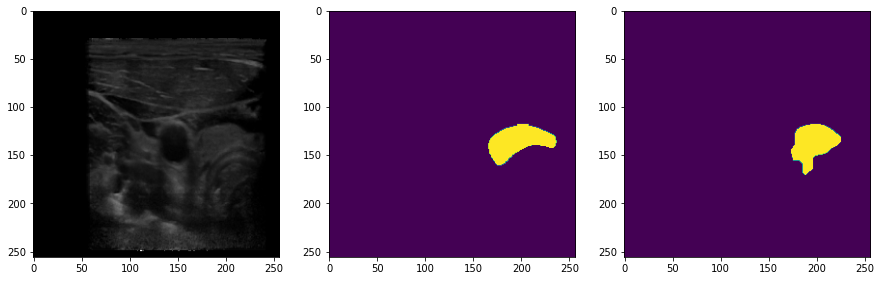

In [27]:

for i in range(10):
  f, axis= plt.subplots(1,3, figsize=(15,15))

  axis[0].imshow(np.squeeze(XTest[i]),cmap= 'gray')
  axis[1].imshow(np.squeeze(np.argmax(YTest, axis = -1)[i]))
  axis[2].imshow(np.squeeze(pred[i]))